In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from IPython.display import SVG
from pylab import rcParams
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Lambda, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.optimizers import Adam, Nadam, SGD
from keras.utils.vis_utils import model_to_dot, plot_model
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

Using TensorFlow backend.


In [2]:
%matplotlib inline

sns.set(style='dark', palette='deep', font_scale=1.5)

rcParams['figure.figsize'] = 15, 10

RANDOM_SEED = 7
LABELS = ["Normal", "Fraud"]

In [3]:
df = pd.read_csv("data/creditcard.csv")
df.shape

(284807, 31)

In [4]:
assert not df.isnull().values.any()

Text(0, 0.5, 'Frequency')

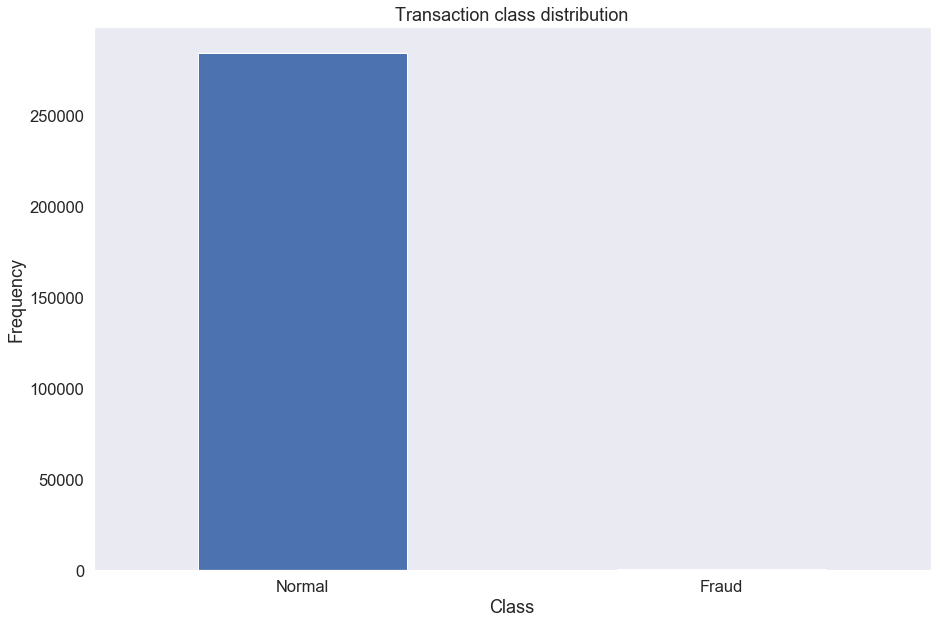

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(len(LABELS)), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

print(frauds.shape)
print(normal.shape)

(492, 31)
(284315, 31)


In [7]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [8]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

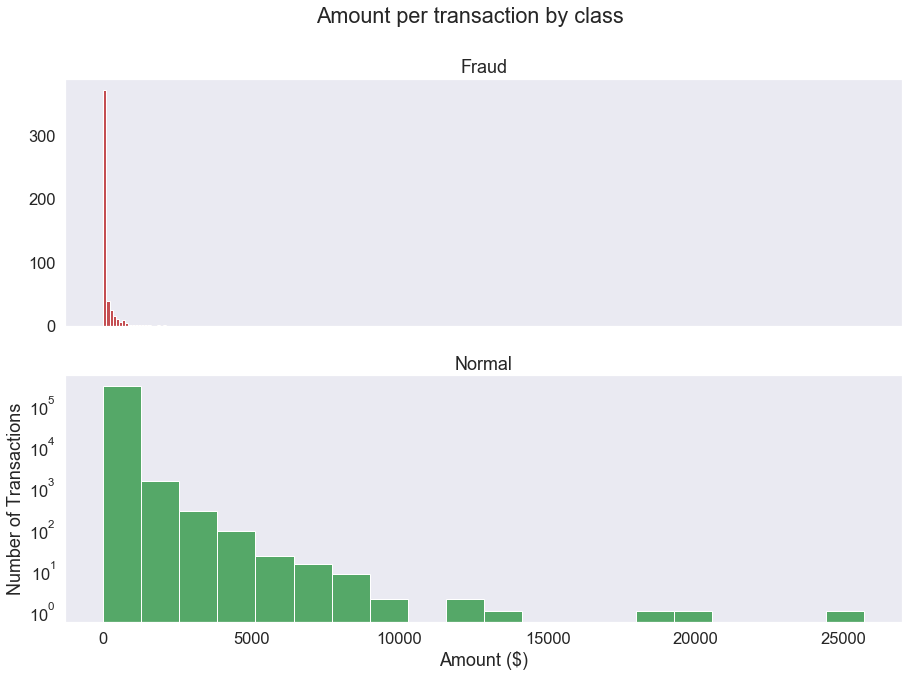

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 20

ax1.hist(frauds.Amount, bins = bins, color='r')
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins, color='g')
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

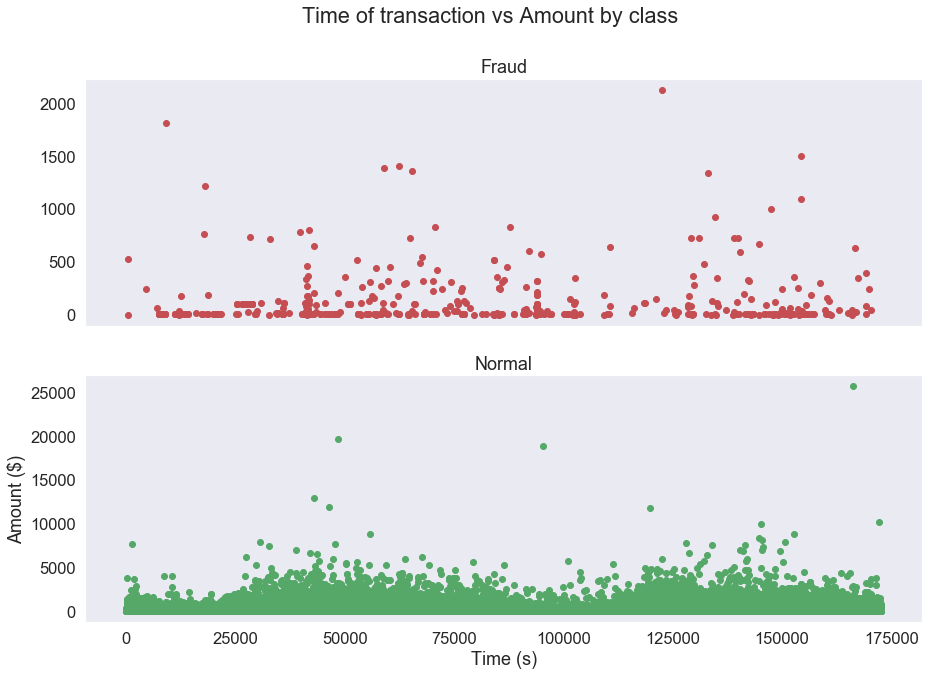

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount, color='r')
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount, color='g')
ax2.set_title('Normal')

plt.xlabel('Time (s)')
plt.ylabel('Amount ($)')
plt.show()

In [11]:
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [12]:
TEST_SIZE=0.2
X_train, X_test = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227453, 29)

In [13]:
input_dim = X_train.shape[1]
hidden_size = int(input_dim/2)
latent_dim = int(input_dim/4)

x = Input(shape=(input_dim,))
t = BatchNormalization()(x)
t = Dense(hidden_size, activation='tanh' , name='encoder_hidden')(t)
t = BatchNormalization()(t)

z_mean = Dense(latent_dim, name='z_mean')(t)
z_log_var = Dense(latent_dim, name='z_log_var')(t)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, name='z_sampled')([z_mean, z_log_var])
#t = BatchNormalization()(z)

t = Dense(hidden_size, activation='tanh', name='decoder_hidden')(z)
#t = BatchNormalization()(t)

decoded_mean = Dense(input_dim, activation=None, name='decoded_mean')(t)

vae = Model(x, decoded_mean)

def rec_loss(y_true, y_pred):
    return K.sum(K.square(y_true - y_pred), axis=-1)

def kl_loss(y_true, y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def vae_loss(x, decoded_mean):
    rec_loss = K.sum(K.square(x - decoded_mean), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean((rec_loss + kl_loss) / 2)

vae.compile(optimizer=Adam(lr=1e-2), loss=vae_loss, metrics=[rec_loss, kl_loss])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 29)           0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 29)           116         input_1[0][0]                    
__________________________________________________________________________________________________
encoder_hidden (Dense)          (None, 14)           420         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 14)           56          encoder_hidden[0][0]             
__________________________________________________________________________________________________
z_mean (De

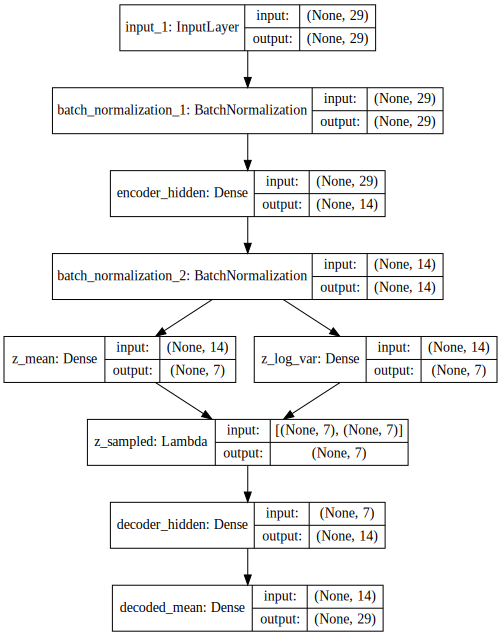

In [14]:
SVG(model_to_dot(vae, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
epochs = 10
batch_size = 32

early_stopping = EarlyStopping(monitor='loss', patience=10, min_delta=1e-5)
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, min_delta=1e-5, factor=0.2)
checkpointer = ModelCheckpoint(filepath="model.h5", verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

callbacks = [early_stopping, reduce_lr, checkpointer, tensorboard]

history = vae.fit(X_train, X_train, 
                  validation_data=(X_test, X_test), 
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  callbacks=callbacks).history

Train on 227453 samples, validate on 56962 samples
Epoch 1/10
227453/227453 [==============================] - 12s 53us/step - loss: 11.1645 - rec_loss: 18.0381 - kl_loss: 4.2909 - val_loss: 11.8065 - val_rec_loss: 19.1924 - val_kl_loss: 4.4205

Epoch 00001: val_loss improved from inf to 11.80648, saving model to model.h5
Epoch 2/10
227453/227453 [==============================] - 11s 50us/step - loss: 10.1263 - rec_loss: 15.8626 - kl_loss: 4.3900 - val_loss: 11.3499 - val_rec_loss: 18.4981 - val_kl_loss: 4.2017

Epoch 00002: val_loss improved from 11.80648 to 11.34988, saving model to model.h5
Epoch 3/10
227453/227453 [==============================] - 11s 49us/step - loss: 10.0090 - rec_loss: 15.6287 - kl_loss: 4.3892 - val_loss: 11.8098 - val_rec_loss: 19.6557 - val_kl_loss: 3.9638

Epoch 00003: val_loss did not improve from 11.34988
Epoch 4/10
227453/227453 [==============================] - 11s 49us/step - loss: 9.9779 - rec_loss: 15.5525 - kl_loss: 4.4034 - val_loss: 11.8220 - va

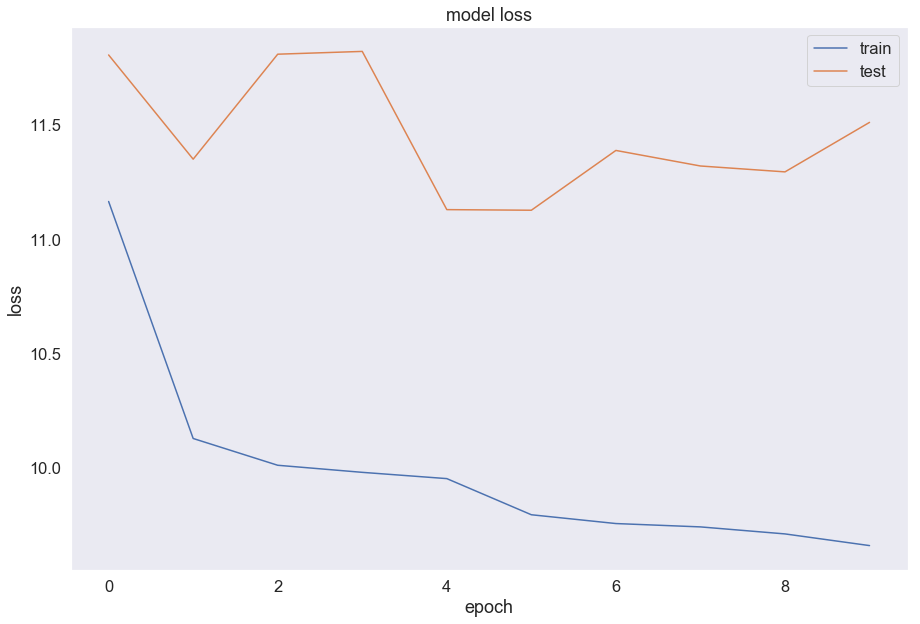

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [17]:
predictions = vae.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.650607,0.001756
std,7.820294,0.041863
min,0.038514,0.000000
25%,0.244850,0.000000
50%,0.357900,0.000000
75%,0.538941,0.000000
max,1657.464069,1.000000


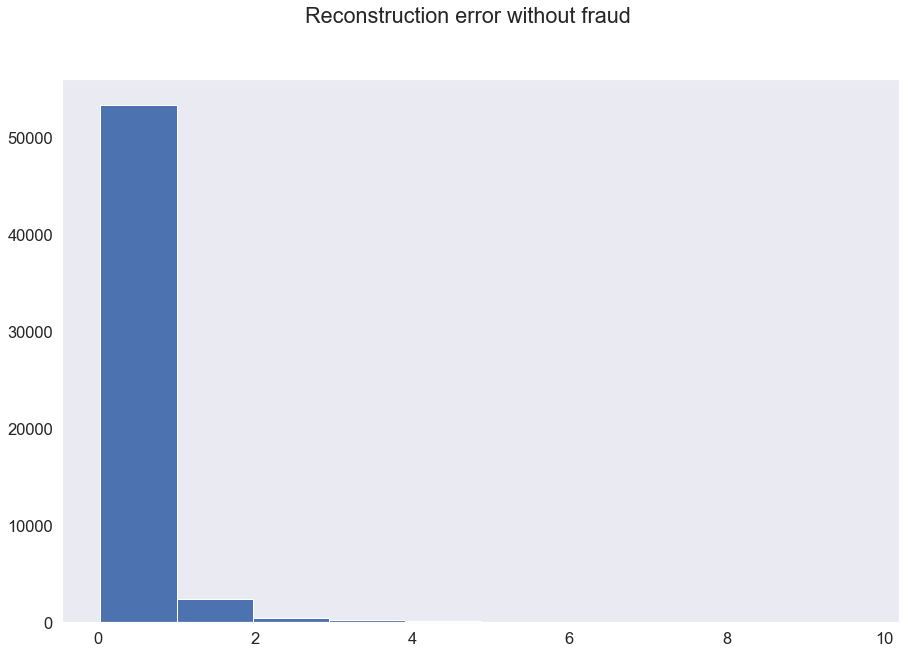

In [18]:
fig = plt.figure()
fig.suptitle('Reconstruction error without fraud')
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

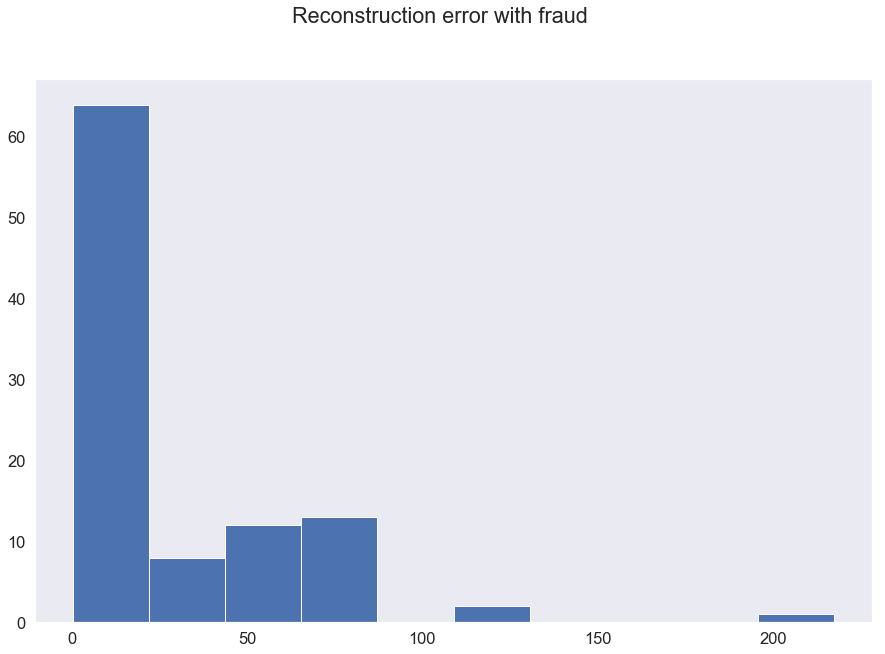

In [19]:
fig = plt.figure()
fig.suptitle('Reconstruction error with fraud')
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

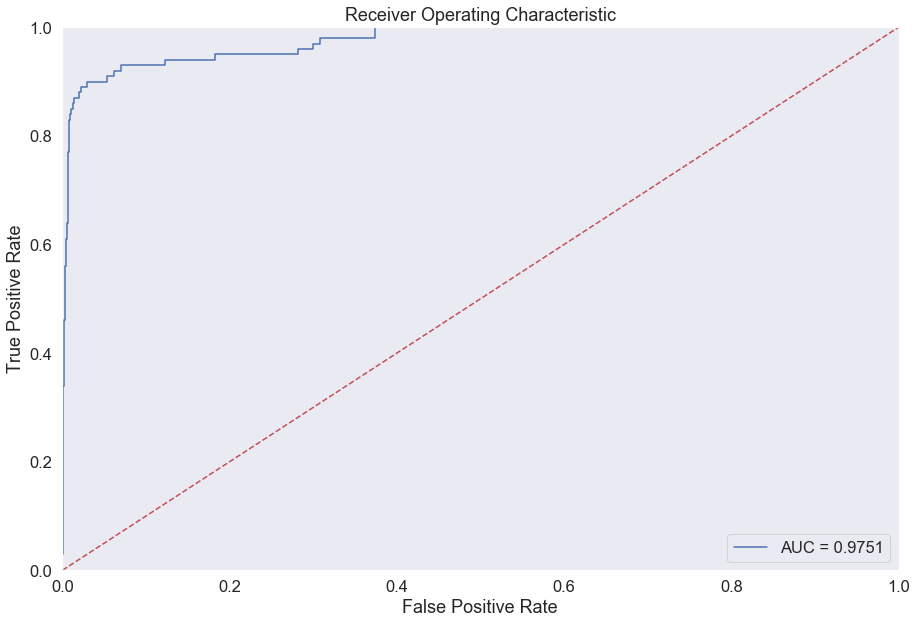

In [20]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

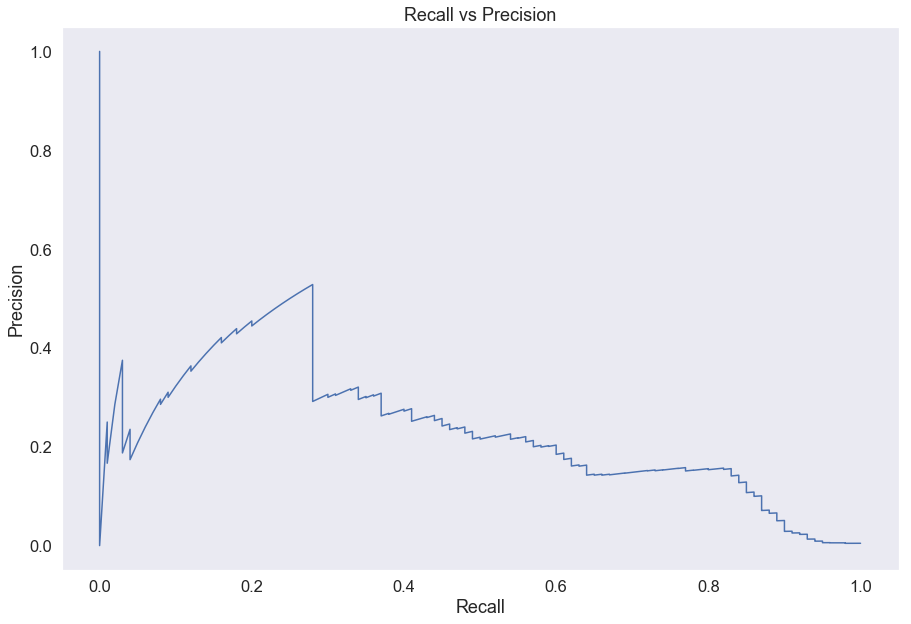

In [21]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

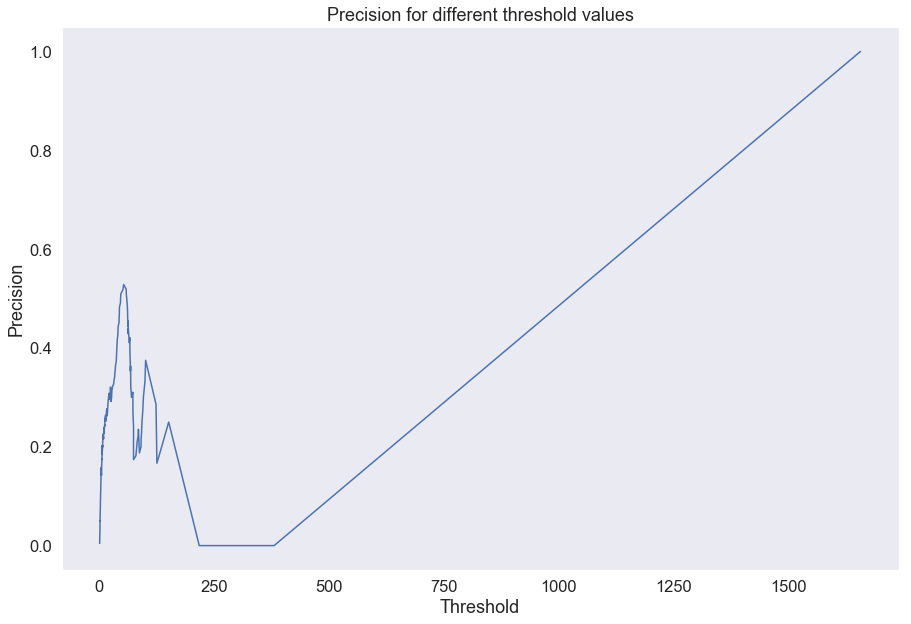

In [22]:
plt.plot(th, precision[1:], color='b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

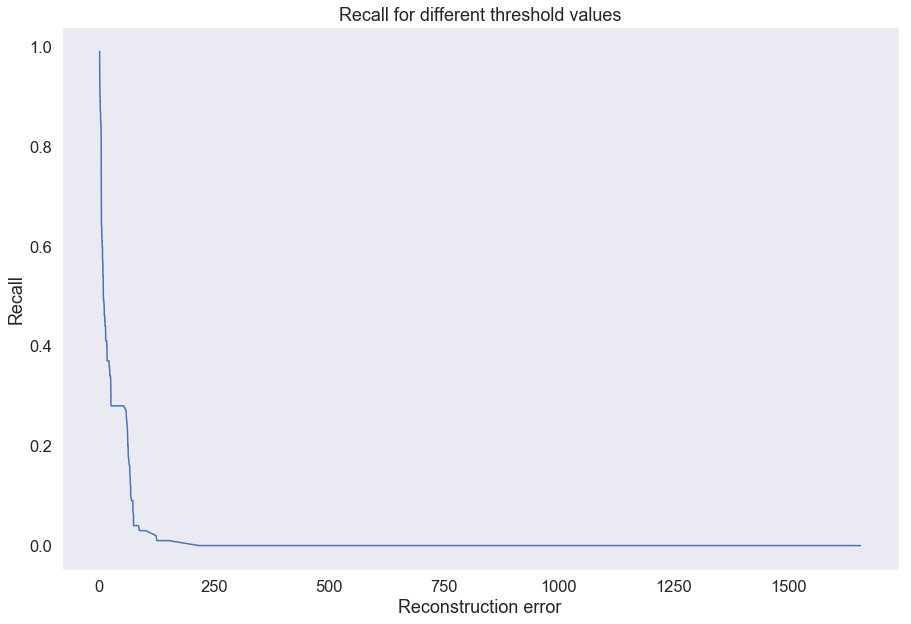

In [23]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

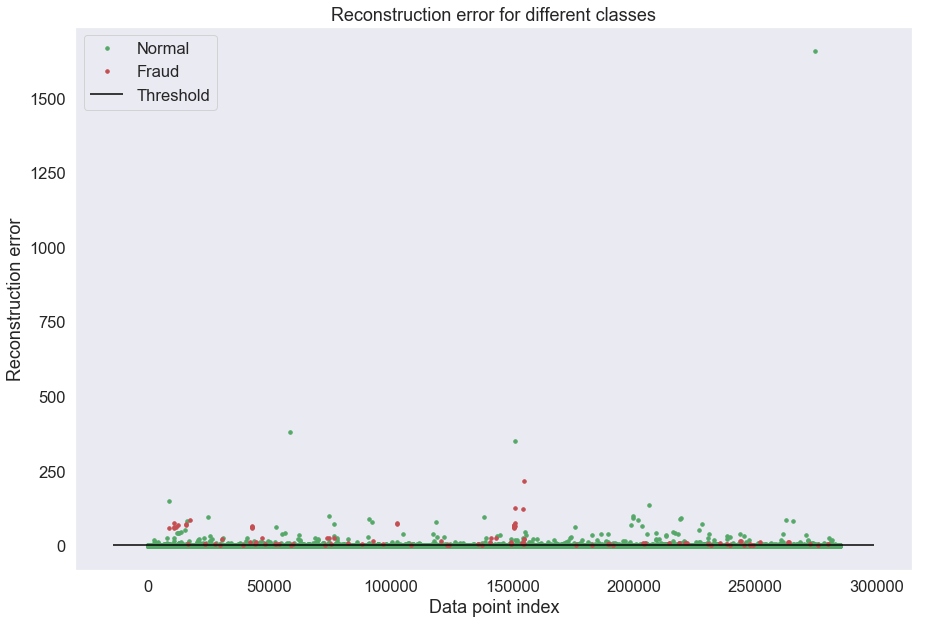

In [24]:
THRESHOLD = 2.75
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal", color='r' if name==1 else 'g')
ax.hlines(THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], colors='black', zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

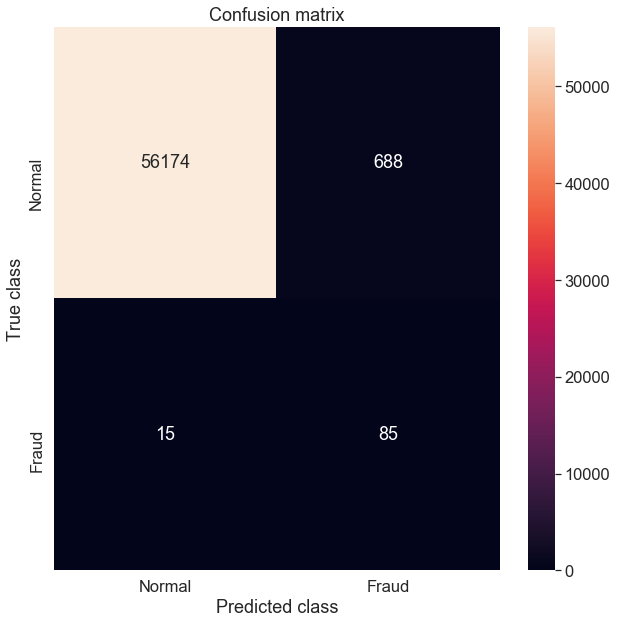

In [26]:
y_pred = [1 if e > THRESHOLD else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()